In [ ]:
%load_ext autoreload
%autoreload 2
from stable_baselines3 import PPO
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.monitor import Monitor
from wrapper.agent_sb import SB3Wrapper
from stable_baselines3.common.callbacks import CheckpointCallback
from wrapper import ROOT
from wrapper.training import EvalCheckpointCallback
import gymnasium as gym
import numpy as np 

env = gym.make("InvertedDoublePendulum-v5")
exp_tag = "rl_test"
exp_dir = ROOT / "runs" / exp_tag
log_dir = exp_dir / ".logs"

In [13]:
callback = EvalCheckpointCallback(
    env=env,
    save_freq=10000,
    save_path=exp_dir,
    n_eval_episodes=1000,
    verbose=1,
)

agent = PPO("MlpPolicy", env).learn(100000, callback=callback)

KeyboardInterrupt: 

In [ ]:
print(agent.device)

In [16]:
agent = PPO("MlpPolicy", env)
agent_wrapper = SB3Wrapper(agent.load(exp_dir / "best_model.zip"))
for weight in agent_wrapper.get_weights():
    print(weight.shape)

(1,)
(64, 9)
(64,)
(64, 64)
(64,)
(64, 9)
(64,)
(64, 64)
(64,)
(1, 64)
(1,)
(1, 64)
(1,)


In [19]:
rollout_kwargs = {"env": env, "n_eval_steps": 1000, "n_episodes": 5}
surface = agent_wrapper.compute_surface(rollout_kwargs, grid_size=25)

In [20]:
import plotly.graph_objects as go

hovertemplate = "<b>Z %{z:.2f}</b> <br>X %{x:.2f}</br>Y %{y:.2f} <extra></extra>"
offsets = agent_wrapper.offsets
fig = go.Figure(
    data=[
        go.Surface(
            x=offsets,
            y=offsets,
            z=surface,
            colorscale="RdBu_r",
            hovertemplate=hovertemplate,
        )
    ]
)

fig.update_traces(
    hovertemplate=hovertemplate,
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.9)",  # white with 70% opacity
        font=dict(color="black"),  # optional: set text color
    ),
)
fig.update_layout(
    # title=dict(text="Reward Surface"),
    # autosize=True,
    width=600,
    height=400,
    margin=dict(l=5, r=5, b=5, t=5),
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),  # squeeze z axis
    ),
)


fig

In [4]:
import itertools

test = np.array(list("ABCD"))

temp = list(itertools.product(test, test))
out = list()
for tup in temp:
    out.append("".join(tup))

out = np.array(out).reshape(len(test), len(test))
out

array([['AA', 'AB', 'AC', 'AD'],
       ['BA', 'BB', 'BC', 'BD'],
       ['CA', 'CB', 'CC', 'CD'],
       ['DA', 'DB', 'DC', 'DD']], dtype='<U2')

Reward at alpha=0 in loop: 752.974510702855


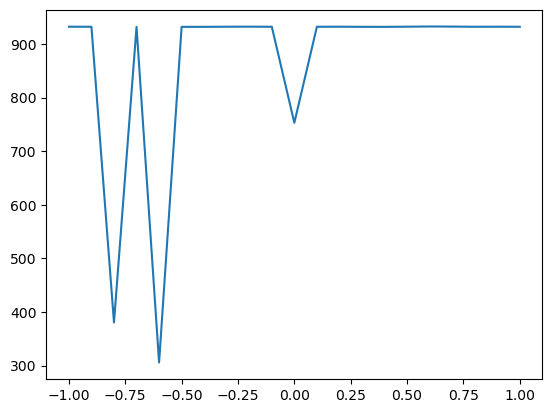

In [15]:
from wrapper.utils import initialize_directions
import matplotlib.pyplot as plt

alphas = np.linspace(-1.0, 1.0, 21)
rewards = []
direction = initialize_directions(agent_wrapper.get_weights())[0]

for alpha in alphas:
    perturbed_weights = []
    for p, p_dir in zip(agent_wrapper.get_weights(), direction):
        perturbed_weights.append(p + p_dir * alpha)
    alt = agent_wrapper.initialize(perturbed_weights)
    reward = alt.estimate_reward(**rollout_kwargs)
    rewards.append(reward)
    if alpha == 0.0:
        print("Reward at alpha=0 in loop:", reward)

plt.plot(alphas, rewards)